<a href="https://colab.research.google.com/github/carlos-alves-one/-AI-Coursework-1/blob/main/glaucoma_detection_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Goldsmiths University of London
### MSc. Data Science and Artificial Intelligence
### Module: Artificial Intelligence
### Author: Carlos Manuel De Oliveira Alves
### Student: cdeol003
### Coursework No.1

#Project
VisionGuard AI: Deep Learning for Early Glaucoma Detection

# Introduction

The purpose of this research is to outline the progression of a deep-learning model designed to identify glaucoma through the analysis of ocular pictures. Glaucoma is a debilitating ocular disorder that, if left undetected and untreated in its early stages, can result in complete vision loss. Effective screening procedures are necessary due to the asymptomatic nature of the early stages of glaucoma. Deep learning, specifically convolutional neural networks (CNNs), has demonstrated considerable potential in image identification tasks and can aid in the early detection of glaucoma. The dataset utilised in this research comprises a collection of ocular pictures accompanied by a binary classification showing the presence or absence of glaucoma. The ExpCDR, or 'Cup to Disc Ratio', is a crucial clinical parameter utilised in evaluating glaucoma for each image.

# Methodology

## Data Preprocessing

The photos will undergo a process of loading, resizing to a consistent dimension, and normalisation to ensure that their pixel values fall within the range of 0 to 1. Furthermore, it is possible to employ data augmentation methods, such as rotations, shifts, and flips, in order to augment the size and diversity of the dataset. This can be beneficial in mitigating the issue of overfitting.

### Load the data

In [1]:
# Imports the 'drive' module from 'google.colab' and mounts the Google Drive to
# the '/content/drive' directory in the Colab environment.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import the pandas library and give it the alias 'pd' for data manipulation and analysis
import pandas as pd

# Load the dataset glaucoma from Google Drive
data_path = '/content/drive/MyDrive/glaucoma.csv'
glaucoma_data = pd.read_csv(data_path)

# Display the first few rows of the dataframe
glaucoma_data.head()


,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0


Dataset source: https://www.kaggle.com/datasets/sshikamaru/glaucoma-detection

License: CC0 - Public Domain
https://creativecommons.org/publicdomain/zero/1.0/

The dataset contains the following columns:

    - Filename: The name of the image file.
    - ExpCDR: The 'Cup to Disc Ratio', a crucial parameter for evaluating glaucoma.
    - Eye: Indicates which eye the image corresponds to (OD for right eye, OS for left eye).
    - Set: This could denote the dataset split (e.g., training, validation, or test set), but we would need further clarification.
    - Glaucoma: The binary label indicating the presence (1) or absence (0) of glaucoma.

###Preprocess the Data

Declare function to preprocess a single image:

In [3]:
# Importing the os module for interacting with the operating system and tensorflow for machine learning tasks
import os
import tensorflow as tf

# Function to preprocess a single image
def preprocess_image(filename, img_height=224, img_width=224, images_directory='/content/drive/MyDrive/Images'):

    # Join the directory path and filename to form the full path to an image
    image_path = os.path.join(images_directory, filename)

    # Read the image file from the specified path into a tensor
    image = tf.io.read_file(image_path)

    # Decode the JPEG image and ensure it has 3 color channels (RGB)
    image = tf.image.decode_jpeg(image, channels=3)

    # Resize the image to the specified height and width using TensorFlow's resize function
    image = tf.image.resize(image, [img_height, img_width])

    # Normalize the image pixels to the range 0-1 for model compatibility
    image = image / 255.0

    # Return image preprocessed
    return image


###Data Augmentation

Set up data augmentation using the ImageDataGenerator class from tf.keras.preprocessing.image.

In [4]:
# Import the ImageDataGenerator class from TensorFlow's Keras API for real-time data augmentation of images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up data augmentation
data_augmentation = ImageDataGenerator(

    # Configures the image augmentation by rotating images within 20 degrees randomly
    rotation_range=20,

    # Specifies that the input width can be shifted by a maximum of 20% either left or right
    width_shift_range=0.2,

    # Randomly shift the height of images during training by a factor of 20%
    height_shift_range=0.2,

    # Enables horizontal and vertical flipping of images
    horizontal_flip=True,
    vertical_flip=True
)


###Apply Preprocessing and Augmentation to Dataset

In [ ]:
# Extract filenames and corresponding glaucoma presence labels from the dataset
filenames = glaucoma_data['Filename'].values
labels = glaucoma_data['Glaucoma'].values

# A placeholder for the images directory
images_directory = '/content/drive/MyDrive/Images'

# Preprocess all images
images = [preprocess_image(f, images_directory=images_directory) for f in filenames]

# Convert to Tensor
images = tf.stack(images)
labels = tf.convert_to_tensor(labels)


###Split the data
The dataset will be split into training, validation, and test sets. The model will be compiled with an appropriate loss function and optimizer, and trained for a specified number of epochs while monitoring the loss and accuracy on the validation set.

In [6]:
# Import train_test_split function from scikit-learn to split data into training and test sets
from sklearn.model_selection import train_test_split

# Import TensorFlow for deep learning and train_test_split function for splitting the dataset into training and testing sets
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Convert image and label tensors to numpy arrays for further manipulation or analysis
images_numpy = images.numpy()
labels_numpy = labels.numpy()

# Split the dataset into training set and a combined validation/test set with a 20% size of the original dataset,
# using a fixed random state for reproducibility.
train_images, val_test_images, train_labels, val_test_labels = train_test_split(
    images_numpy, labels_numpy, test_size=0.2, random_state=42
)

# Split the val_test set equally into validation and test sets (50% validation, 50% test)
val_images, test_images, val_labels, test_labels = train_test_split(
    val_test_images, val_test_labels, test_size=0.5, random_state=42)


## Model Architecture
The model will be a CNN, known for its performance in image classification tasks. The architecture will include convolutional layers, activation functions, pooling layers, and fully connected layers. Dropout layers may be included to reduce overfitting.

In [7]:
# Import TensorFlow and essential layers for building a Convolutional Neural Network (CNN)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model architecture:

# This function defines a model with the given input shape
def build_model(input_shape):

    # Initialize a Sequential model
    model = Sequential([

        # Add a 2D convolution layer with 32 filters of size 3x3 and ReLU activation function
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),

        # Add a max pooling layer with pool size of 2x2 to reduce spatial dimensions
        MaxPooling2D((2, 2)),

        # Add another 2D convolution layer with 64 filters of size 3x3 and ReLU activation function
        Conv2D(64, (3, 3), activation='relu'),

        # Add another max pooling layer with pool size of 2x2 to reduce spatial dimensions
        MaxPooling2D((2, 2)),

        # Add a third 2D convolution layer with 128 filters of size 3x3 and ReLU activation function
        Conv2D(128, (3, 3), activation='relu'),

        # Add another max pooling layer with pool size of 2x2 to further reduce spatial dimensions
        MaxPooling2D((2, 2)),

        # Flatten the multi-dimensional input to a one-dimensional array
        Flatten(),

        # Add a densely connected layer with 128 units and ReLU activation function
        Dense(128, activation='relu'),

        # Add a dropout layer with a dropout rate of 0.5 to prevent overfitting
        Dropout(0.5),

        # Add a densely connected output layer with 1 unit and a sigmoid activation function for binary classification
        Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
    ])

    # Return the constructed model
    return model

# Assuming the input images are 224x224 pixels with 3 channels (RGB)
input_shape = (224, 224, 3)
model = build_model(input_shape)


## Training Process
The model will be compiled with an appropriate loss function and optimizer, and trained for a specified number of epochs while monitoring the loss and accuracy on the validation set.

In [8]:
# Compile the model:

model.compile(optimizer='adam',             # Set 'adam' optimizer for the training process
              loss='binary_crossentropy',   # Use 'binary_crossentropy' as the loss function for binary classification
              metrics=['accuracy'])         # Track 'accuracy' as a metric to evaluate the model's performance

# Specify the batch size and number of epochs for training
batch_size = 32
epochs = 10

# Train the model:

# Start training the model with the training dataset
history = model.fit(train_images, train_labels,

                    # Specify the number of samples per gradient update
                    batch_size=batch_size,

                    # Set the number of iterations over the entire dataset
                    epochs=epochs,

                    # Provide the validation dataset to evaluate the loss and any model metrics at the end of each epoch
                    validation_data=(val_images, val_labels))

Epoch 1/10
17/17 [==============================] - 79s 4s/step - loss: 0.6382 - accuracy: 0.6808 - val_loss: 0.6608 - val_accuracy: 0.7538
Epoch 2/10
17/17 [==============================] - 65s 4s/step - loss: 0.6333 - accuracy: 0.7231 - val_loss: 0.5825 - val_accuracy: 0.7538
Epoch 3/10
17/17 [==============================] - 57s 3s/step - loss: 0.5719 - accuracy: 0.7423 - val_loss: 0.5645 - val_accuracy: 0.7538
Epoch 4/10
17/17 [==============================] - 67s 4s/step - loss: 0.5861 - accuracy: 0.7423 - val_loss: 0.5718 - val_accuracy: 0.7538
Epoch 5/10
17/17 [==============================] - 60s 4s/step - loss: 0.5857 - accuracy: 0.7423 - val_loss: 0.5801 - val_accuracy: 0.7538
Epoch 6/10
17/17 [==============================] - 59s 3s/step - loss: 0.5882 - accuracy: 0.7423 - val_loss: 0.5734 - val_accuracy: 0.7538
Epoch 7/10
17/17 [==============================] - 60s 4s/step - loss: 0.5890 - accuracy: 0.7423 - val_loss: 0.5645 - val_accuracy: 0.7538
Epoch 8/10
17/17 [==

# Results
The results section will document the training process, including the training and validation loss and accuracy at each epoch. Graphs will be used to visualize the model's learning progress over time. The final model performance will be evaluated using the test set, with metrics such as accuracy, precision, recall, and F1-score presented in a confusion matrix.

##Plot training and validation loss and accuracy

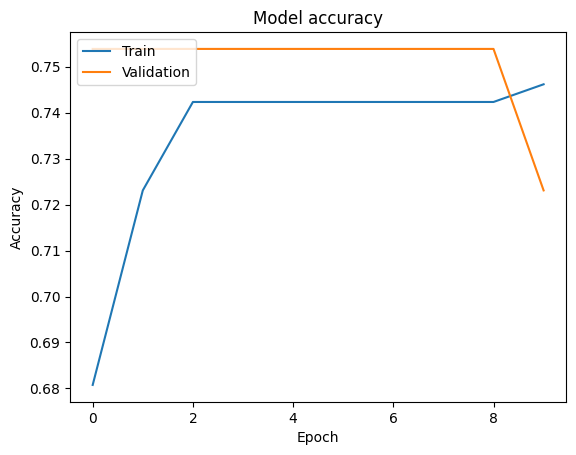

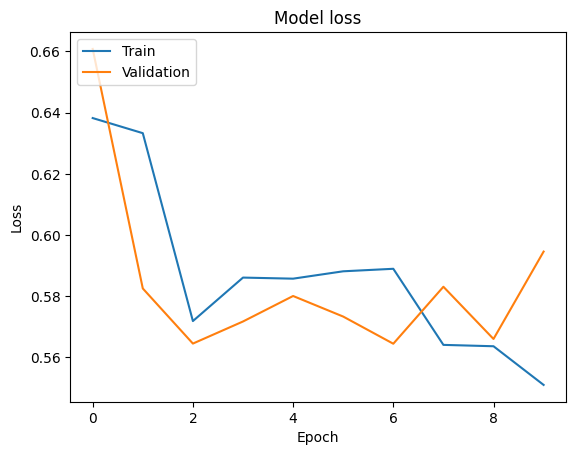

In [9]:
# Import the pyplot submodule from matplotlib and alias it as plt
import matplotlib.pyplot as plt

# Use the history callback returned from the 'fit' training process
# which contains the loss and accuracy for each epoch

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
